In [33]:
from accelerate import Accelerator
from accelerate.utils import tqdm as accel_tqdm


from dataclasses import dataclass
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, DDIMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.schedulers.scheduling_utils import SchedulerMixin
from diffusers.utils import make_image_grid

from huggingface_hub import notebook_login, create_repo, upload_folder

import os

from PIL import Image

from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer, Adam
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import matplotlib.pyplot as plt


In [51]:
notebook_login()

In [35]:
!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [64]:
@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 64
    eval_batch_size = 16  # how many images to sample during evaluation
    # num_epochs = 100
    num_epochs = 300
    gradient_accumulation_steps = 1
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 25
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddim-flowers-64"  # the model name locally and on the HF Hub
    dataset_name = "nkirschi/oxford-flowers"
    log_dir = "/kaggle/working/runs/exp1"
    
    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "FlewRr/ddim_flowers"  # the name of the repository to create on the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

    # lr = 1e-4
    lr = 5e-5
    timesteps=1000
    device="cuda:0"
    
config = TrainingConfig()

In [37]:
dataset = load_dataset(config.dataset_name, split="train")
dataset = dataset.remove_columns("label")

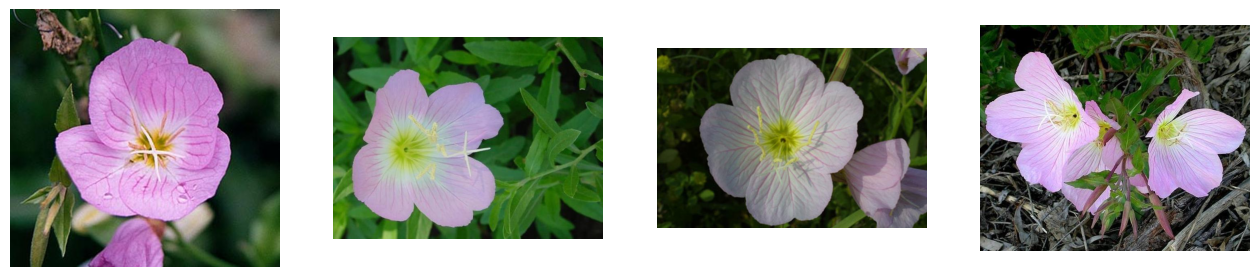

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [39]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [61]:
def evaluate(config: TrainingConfig, epoch: int, pipeline, nrows=4, ncols=4):
    pipeline = pipeline.to(device=config.device)
    
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=config.device).manual_seed(config.seed)
    ).images

    
    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [41]:
# !cd /kaggle/working; rm -rf ./*

In [42]:
import wandb

In [62]:
def train(config: TrainingConfig, model: nn.Module, optimizer: Optimizer, train_dataloader: DataLoader, lr_scheduler: LRScheduler, train_scheduler: SchedulerMixin, eval_scheduler: SchedulerMixin):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")
        
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    global_step = 0

    for epoch in range(config.num_epochs):
        model.train()
        epoch_bar = accel_tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{config.num_epochs}")

        total_loss = 0.
        for batch in epoch_bar:
            images = batch["images"]
            noise = torch.randn_like(images)
            timesteps = torch.randint(0, train_scheduler.config.num_train_timesteps, (images.shape[0],), device=images.device,
                                      dtype=torch.long)
    
            noisy_images = train_scheduler.add_noise(images, noise, timesteps)
    
            with accelerator.accumulate(model):
    
                noise_pred = model(noisy_images, timesteps).sample
    
                loss = F.mse_loss(noise_pred, noise)
                total_loss += loss.item()
                
                accelerator.backward(loss)
    
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
    
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            if accelerator.is_main_process:
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
                epoch_bar.set_postfix(**logs)
                accelerator.log(logs, step=global_step)
                
            global_step += 1

        wandb_logs = {"loss": total_loss / len(train_dataloader)}
        wandb.log(wandb_logs)
        
        if accelerator.is_main_process:
            pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=eval_scheduler)
    
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
    
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [46]:
# model = UNet2DModel(
#     sample_size=config.image_size,
#     in_channels=3,
#     out_channels=3,
#     layers_per_block=2,
#     block_out_channels=(128, 128, 256, 256, 512, 512),
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",
#         "AttnUpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#     ),
# )

# ddpm_scheduler = DDPMScheduler(num_train_timesteps=config.timesteps) # is trained
# ddim_scheduler = DDIMScheduler.from_config(ddpm_scheduler.config) # is sampled from

# train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
# optimizer = Adam(model.parameters(), lr=config.lr)
# lr_scheduler = get_cosine_schedule_with_warmup(
#     optimizer=optimizer,
#     num_warmup_steps=config.lr_warmup_steps,
#     num_training_steps=(len(train_dataloader) * config.num_epochs),
# )

In [47]:
model = UNet2DModel.from_pretrained("FlewRr/ddim_flowers", subfolder="unet")

ddpm_scheduler = DDPMScheduler(num_train_timesteps=config.timesteps) # is trained
ddim_scheduler = DDIMScheduler.from_config(ddpm_scheduler.config) # is sampled from

train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
optimizer = Adam(model.parameters(), lr=config.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [65]:
from accelerate import notebook_launcher

args = (config, model, optimizer, train_dataloader, lr_scheduler, ddpm_scheduler, ddim_scheduler)

notebook_launcher(train, args, num_processes=1)

Launching training on one GPU.


Epoch 1/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 22/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 23/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 24/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 25/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

events.out.tfevents.1748696120.db77c05535b1.35.0:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Upload 12 LFS files:   0%|          | 0/12 [00:00<?, ?it/s]

events.out.tfevents.1748696446.db77c05535b1.35.2:   0%|          | 0.00/206 [00:00<?, ?B/s]

events.out.tfevents.1748696592.db77c05535b1.35.4:   0%|          | 0.00/143k [00:00<?, ?B/s]

events.out.tfevents.1748696147.db77c05535b1.35.1:   0%|          | 0.00/86.7k [00:00<?, ?B/s]

events.out.tfevents.1748696470.db77c05535b1.35.3:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

events.out.tfevents.1748699262.db77c05535b1.35.5:   0%|          | 0.00/143k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/358k [00:00<?, ?B/s]

0004.png:   0%|          | 0.00/112k [00:00<?, ?B/s]

0009.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

0014.png:   0%|          | 0.00/130k [00:00<?, ?B/s]

0019.png:   0%|          | 0.00/147k [00:00<?, ?B/s]

0024.png:   0%|          | 0.00/139k [00:00<?, ?B/s]

Epoch 26/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 27/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 28/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 29/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 30/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 32/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 33/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 34/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 35/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 37/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 38/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 39/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 40/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 42/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 43/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 44/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 45/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 47/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 48/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 49/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 50/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0034.png:   0%|          | 0.00/137k [00:00<?, ?B/s]

0029.png:   0%|          | 0.00/140k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/717k [00:00<?, ?B/s]

0039.png:   0%|          | 0.00/137k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0044.png:   0%|          | 0.00/140k [00:00<?, ?B/s]

0049.png:   0%|          | 0.00/138k [00:00<?, ?B/s]

Epoch 51/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 52/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 53/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 54/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 55/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 57/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 58/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 59/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 60/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 62/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 63/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 64/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 65/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 67/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 68/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 69/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 70/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 72/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 73/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 74/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 75/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0069.png:   0%|          | 0.00/126k [00:00<?, ?B/s]

0054.png:   0%|          | 0.00/137k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

0064.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

0059.png:   0%|          | 0.00/136k [00:00<?, ?B/s]

0074.png:   0%|          | 0.00/123k [00:00<?, ?B/s]

Epoch 76/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 77/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 78/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 79/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 80/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 81/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 82/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 83/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 84/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 85/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 86/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 87/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 88/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 89/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 90/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 91/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 92/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 93/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 94/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 95/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 96/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 97/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 98/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 99/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 100/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

0079.png:   0%|          | 0.00/140k [00:00<?, ?B/s]

0089.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

0094.png:   0%|          | 0.00/139k [00:00<?, ?B/s]

0084.png:   0%|          | 0.00/128k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0099.png:   0%|          | 0.00/134k [00:00<?, ?B/s]

Epoch 101/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 102/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 103/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 104/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 105/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 106/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 107/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 108/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 109/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 110/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 111/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 112/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 113/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 114/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 115/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 116/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 117/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 118/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 119/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 120/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 121/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 122/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 123/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 124/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 125/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0119.png:   0%|          | 0.00/138k [00:00<?, ?B/s]

0109.png:   0%|          | 0.00/126k [00:00<?, ?B/s]

0114.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

0104.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

0124.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

Epoch 126/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 127/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 128/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 129/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 130/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 131/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 132/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 133/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 134/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 135/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 136/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 137/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 138/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 139/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 140/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 141/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 142/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 143/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 144/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 145/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 146/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 147/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 148/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 149/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 150/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0144.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0134.png:   0%|          | 0.00/121k [00:00<?, ?B/s]

0139.png:   0%|          | 0.00/130k [00:00<?, ?B/s]

0129.png:   0%|          | 0.00/120k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

0149.png:   0%|          | 0.00/139k [00:00<?, ?B/s]

Epoch 151/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 152/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 153/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 154/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 155/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 156/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 157/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 158/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 159/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 160/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 161/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 162/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 163/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 164/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 165/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 166/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 167/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 168/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 169/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 170/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 171/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 172/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 173/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 174/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 175/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0159.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

0164.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0154.png:   0%|          | 0.00/138k [00:00<?, ?B/s]

0169.png:   0%|          | 0.00/139k [00:00<?, ?B/s]

0174.png:   0%|          | 0.00/139k [00:00<?, ?B/s]

Epoch 176/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 177/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 178/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 179/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 180/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 181/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 182/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 183/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 184/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 185/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 186/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 187/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 188/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 189/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 190/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 191/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 192/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 193/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 194/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 195/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 196/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 197/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 198/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 199/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 200/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0189.png:   0%|          | 0.00/141k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0194.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

0179.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

0184.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

0199.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

Epoch 201/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 202/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 203/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 204/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 205/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 206/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 207/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 208/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 209/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 210/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 211/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 212/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 213/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 214/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 215/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 216/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 217/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 218/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 219/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 220/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 221/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 222/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 223/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 224/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 225/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0214.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

0219.png:   0%|          | 0.00/138k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

0204.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

0209.png:   0%|          | 0.00/129k [00:00<?, ?B/s]

0224.png:   0%|          | 0.00/136k [00:00<?, ?B/s]

Epoch 226/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 227/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 228/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 229/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 230/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 231/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 232/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 233/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 234/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 235/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 236/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 237/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 238/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 239/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 240/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 241/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 242/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 243/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 244/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 245/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 246/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 247/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 248/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 249/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 250/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0234.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

0244.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

0239.png:   0%|          | 0.00/128k [00:00<?, ?B/s]

0229.png:   0%|          | 0.00/135k [00:00<?, ?B/s]

0249.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

Epoch 251/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 252/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 253/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 254/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 255/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 256/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 257/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 258/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 259/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 260/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 261/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 262/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 263/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 264/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 265/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 266/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 267/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 268/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 269/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 270/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 271/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 272/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 273/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 274/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 275/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0264.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0259.png:   0%|          | 0.00/133k [00:00<?, ?B/s]

0254.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

0269.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

0274.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

Epoch 276/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 277/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 278/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 279/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 280/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 281/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 282/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 283/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 284/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 285/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 286/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 287/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 288/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 289/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 290/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 291/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 292/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 293/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 294/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 295/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 296/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 297/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 298/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 299/300:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 300/300:   0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0289.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

0279.png:   0%|          | 0.00/131k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

0284.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

0294.png:   0%|          | 0.00/132k [00:00<?, ?B/s]

events.out.tfevents.1748701159.db77c05535b1.35.6:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

0299.png:   0%|          | 0.00/132k [00:00<?, ?B/s]